In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

import pandas as pd
import numpy as np

import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
nltk.download('stopwords')
nltk.download('punkt')

from nltk.stem import WordNetLemmatizer #this is used in lemmatization
nltk.download('wordnet') # this is required for lemmatization

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import  recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import  auc
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [3]:
#reading the file
df_data = pd.read_csv("/content/drive/My Drive/NLP_PRACTICE/Fake_news_classifier/train.csv")

In [4]:
#displaying the file
df_data.head(10)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,NaN,Ever wonder how Britain’s most iconic pop pian...,1
7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0
8,8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0
9,9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0


In [5]:
#checking for null values
df_data.isnull().sum()
df_data.reset_index(inplace=True)

In [6]:
#dropping the null values
df_data.dropna(inplace=True)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


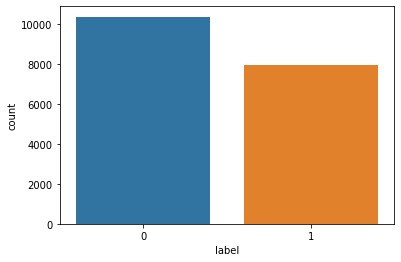

In [7]:
#checking class distribution
sns.countplot(df_data['label'])

In [8]:
# Function for generating word clouds
def generate_wordcloud(data,title):
  wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(data)
  plt.figure(figsize=(10,8))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.title('\n'.join(wrap(title,60)),fontsize=13)
  plt.show()

In [9]:
#cleaning the data

def text_process(df,columns):

  lamm = WordNetLemmatizer()
  tokenizer = RegexpTokenizer(r'\w+')
  corpus = []

  for i in df[columns]:
    
    #remove url's
    sentence = re.sub(r"http\S+", " ", i).lower()

    # #removing characters other than alphabets
    sentence = re.sub('[^a-zA-Z]',' ',sentence)

    # #removing spaces
    cleaned_sentence = re.sub(r'\s+',' ',sentence)

    #tokenize
    cleaned_sentence = tokenizer.tokenize(cleaned_sentence)

    # # remove any stopwords 
    cleaned_sentence = [lamm.lemmatize(word) for word in cleaned_sentence if word.lower() not in stopwords.words('english')]

     # # Join the characters again to form the string.
    cleaned_sentence = ' '.join(cleaned_sentence)

    corpus.append(cleaned_sentence)

  return corpus

In [10]:
#data cleaning
Corpus = text_process(df_data,columns='text')

In [11]:
def evaluate_model(y_test, predicted, predicted_prob, show_thresholds=True, figsize=(25,5)):
    classes = np.unique(y_test)
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    
    ## Accuray e AUC
    accuracy = metrics.accuracy_score(y_test, predicted)
    auc = metrics.roc_auc_score(y_test, predicted_prob)
    print("Accuracy (overall correct predictions):",  round(accuracy,2))
    print("Auc:", round(auc,2))
    
    ## Precision e Recall
    recall = metrics.recall_score(y_test, predicted)  #= true 1s / all 1s in test (got and missed)
    precision = metrics.precision_score(y_test, predicted)  #= true 1s / all 1s predicted (true 1s + false 1s)
    f1 = metrics.f1_score(y_test, predicted)  #=2 * (precision * recall) / (precision + recall)
    print("Recall (all 1s predicted right):", round(recall,2))  #true positive rate, how many 1s I got
    print("Precision (confidence when predicting a 1):", round(precision,2))  #how many 1s were really 1s
    print("F1 score:", round(f1,2))
    print("Detail:")
    print(metrics.classification_report(y_test, predicted, target_names=[str(i) for i in classes]))
       
    ## Plot confusion matrix
    cm = metrics.confusion_matrix(y_test, predicted, labels=classes)
    sns.heatmap(cm, annot=True, annot_kws={"size":15}, fmt='d', ax=ax[0], cmap=plt.cm.Blues, cbar=False)
    ax[0].set(xlabel="Pred", ylabel="True", title="Confusion matrix")
    ax[0].set_yticklabels(labels=classes, rotation=0)
 
    ## Plot roc
    fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted_prob)    
    ax[1].plot(fpr, tpr, color='darkorange', lw=3, label='area = %0.2f' % metrics.auc(fpr, tpr))
    ax[1].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[1].hlines(y=recall, xmin=-0.05, xmax=1-cm[0,0]/(cm[0,0]+cm[0,1]), color='red', linestyle='--', alpha=0.7, label="chosen threshold")
    ax[1].vlines(x=1-cm[0,0]/(cm[0,0]+cm[0,1]), ymin=0, ymax=recall, color='red', linestyle='--', alpha=0.7)
    ax[1].set(xlim=[-0.05,1], ylim=[0.0,1.05], xlabel='False Positive Rate', ylabel="True Positive Rate (Recall)", title="ROC Curve")     
    ax[1].legend(loc="lower right")
    ax[1].grid(True)
    if show_thresholds is True:
        thres_in_plot = []
        for i,t in enumerate(thresholds):
            t = np.round(t,1)
            if t not in thres_in_plot:
                ax[1].annotate(t, xy=(fpr[i],tpr[i]), xytext=(fpr[i],tpr[i]), textcoords='offset points', ha='left', va='bottom')
                thres_in_plot.append(t)
            else:
                next
    
    ## Plot precision-recall curve
    precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, predicted_prob)
    ax[2].plot(recalls, precisions, color='darkorange', lw=3, label='area = %0.2f' % metrics.auc(recalls, precisions))
    ax[2].plot([0,1], [(cm[1,0]+cm[1,0])/len(y_test), (cm[1,0]+cm[1,0])/len(y_test)], linestyle='--', color='navy', lw=3)
    ax[2].hlines(y=precision, xmin=0, xmax=recall, color='red', linestyle='--', alpha=0.7, label="chosen threshold")
    ax[2].vlines(x=recall, ymin=0, ymax=precision, color='red', linestyle='--', alpha=0.7)
    ax[2].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")
    ax[2].legend(loc="lower left")
    ax[2].grid(True)
    if show_thresholds is True:
        thres_in_plot = []
        for i,t in enumerate(thresholds):
            t = np.round(t,1)
            if t not in thres_in_plot:
                ax[2].annotate(np.round(t,1), xy=(recalls[i],precisions[i]), xytext=(recalls[i],precisions[i]), textcoords='offset points', ha='right', va='bottom')
                thres_in_plot.append(t)
            else:
                next
    plt.show()

In [12]:
def transform_feature(data,tech):

  if tech == 'bow':
    bow = CountVectorizer(max_features=5000,ngram_range=(1,3))
    x = bow.fit_transform(data).toarray()
  elif tech == 'tfidf':
    tfidf = TfidfVectorizer(max_features=5000,ngram_range=(1,3))
    x = tfidf.fit_transform(data).toarray()
  
  return x

In [13]:
#transforming the feature

x = transform_feature(Corpus,tech='bow')

In [14]:
#split the data
def split_data(x,y):
  
  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=100)

  return X_train, X_test, y_train, y_test

In [15]:
#getting splited data
X_train, X_test, y_train, y_test = split_data(x,df_data['label'])

In [16]:
X_train.shape, X_test.shape,y_train.shape, y_test.shape

((14628, 5000), (3657, 5000), (14628,), (3657,))

## **Using BoW**

**MultinomialNB**

Accuracy (overall correct predictions): 0.88
Auc: 0.95
Recall (all 1s predicted right): 0.84
Precision (confidence when predicting a 1): 0.89
F1 score: 0.86
Detail:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      2068
           1       0.89      0.84      0.86      1589

    accuracy                           0.88      3657
   macro avg       0.89      0.88      0.88      3657
weighted avg       0.88      0.88      0.88      3657



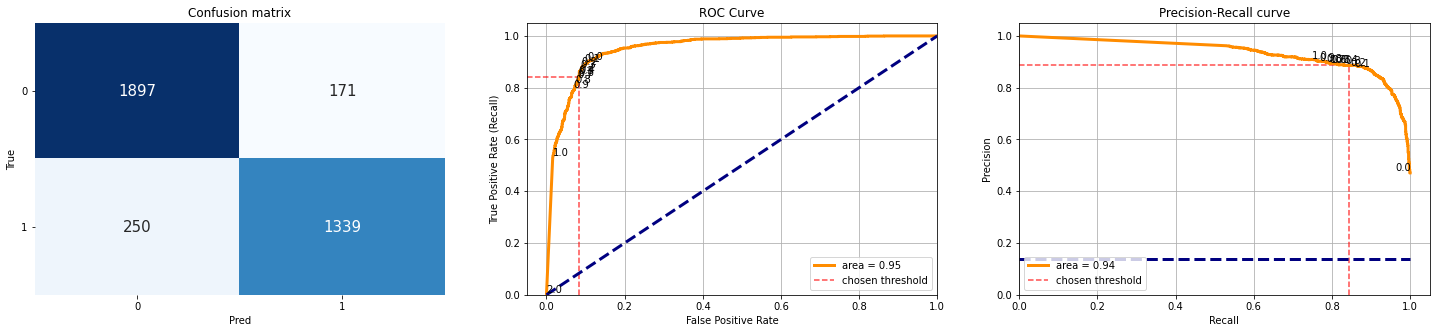

In [17]:
from sklearn.naive_bayes import MultinomialNB
nb=MultinomialNB()
nb.fit(X_train,y_train)
predict_MNB = nb.predict(X_test)
predicted_prob = nb.predict_proba(X_test)[:,1]
evaluate_model(y_test,predict_MNB, predicted_prob, figsize=(25,5))

**Random Forest**

Accuracy (overall correct predictions): 0.95
Auc: 0.99
Recall (all 1s predicted right): 0.93
Precision (confidence when predicting a 1): 0.96
F1 score: 0.95
Detail:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      2068
           1       0.96      0.93      0.95      1589

    accuracy                           0.95      3657
   macro avg       0.95      0.95      0.95      3657
weighted avg       0.95      0.95      0.95      3657



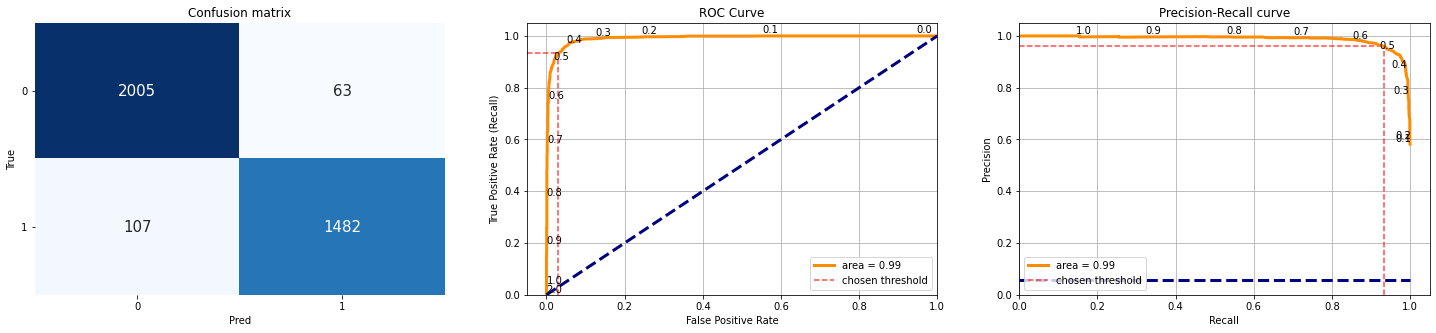

In [18]:
# implement RandomForest Classifier
from sklearn.ensemble import RandomForestClassifier
randomclassifier=RandomForestClassifier(n_estimators=200,criterion='entropy')
randomclassifier.fit(X_train,y_train)
predict_rf = randomclassifier.predict(X_test)
predicted_prob_rf = randomclassifier.predict_proba(X_test)[:,1]
evaluate_model(y_test,predict_rf, predicted_prob_rf, figsize=(25,5))

**Support Vector Classifier**

Accuracy (overall correct predictions): 0.94
Auc: 0.98
Recall (all 1s predicted right): 0.94
Precision (confidence when predicting a 1): 0.92
F1 score: 0.93
Detail:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      2068
           1       0.92      0.94      0.93      1589

    accuracy                           0.94      3657
   macro avg       0.94      0.94      0.94      3657
weighted avg       0.94      0.94      0.94      3657



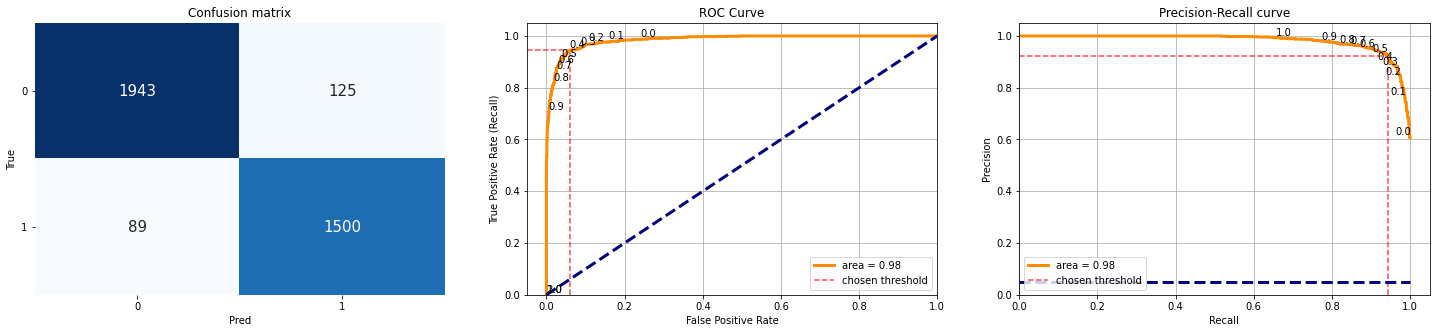

In [ ]:
# implement SVC Classifier
from sklearn.svm import SVC
svc=SVC(probability=True)
svc.fit(X_train,y_train)
predict_svc = svc.predict(X_test)
predicted_prob_svc = svc.predict_proba(X_test)[:,1]
evaluate_model(y_test,predict_svc, predicted_prob_svc, figsize=(25,5))

Passive Aggressive classifier

Accuracy (overall correct predictions): 0.94
Auc: 0.98
Recall (all 1s predicted right): 0.94
Precision (confidence when predicting a 1): 0.93
F1 score: 0.93
Detail:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2068
           1       0.93      0.94      0.93      1589

    accuracy                           0.94      3657
   macro avg       0.94      0.94      0.94      3657
weighted avg       0.94      0.94      0.94      3657



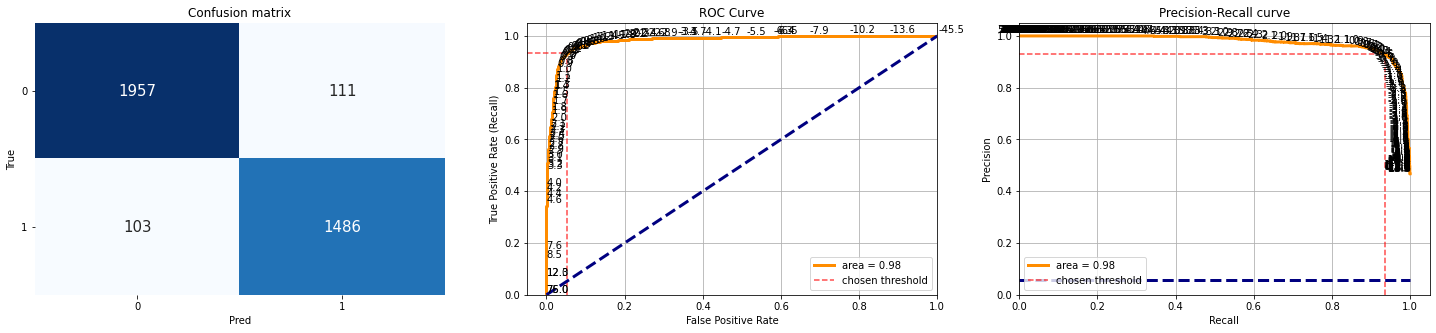

In [19]:
from sklearn.linear_model import PassiveAggressiveClassifier

pac = PassiveAggressiveClassifier()
pac.fit(X_train,y_train)
predict_pac = pac.predict(X_test)
predicted_prob_pac = pac.decision_function(X_test)
evaluate_model(y_test,predict_pac, predicted_prob_pac, figsize=(25,5))

Recall (all 1s predicted right): 0.94
Precision (confidence when predicting a 1): 0.93
F1 score: 0.93
Detail:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2068
           1       0.93      0.94      0.93      1589

    accuracy                           0.94      3657
   macro avg       0.94      0.94      0.94      3657
weighted avg       0.94      0.94      0.94      3657



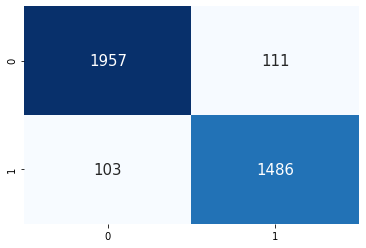

In [20]:
recall = metrics.recall_score(y_test, predict_pac)  #= true 1s / all 1s in test (got and missed)
precision = metrics.precision_score(y_test, predict_pac)  #= true 1s / all 1s predicted (true 1s + false 1s)
f1 = metrics.f1_score(y_test, predict_pac)  #=2 * (precision * recall) / (precision + recall)
print("Recall (all 1s predicted right):", round(recall,2))  #true positive rate, how many 1s I got
print("Precision (confidence when predicting a 1):", round(precision,2))  #how many 1s were really 1s
print("F1 score:", round(f1,2))
print("Detail:")
classes = np.unique(y_test)
print(metrics.classification_report(y_test, predict_pac, target_names=[str(i) for i in classes]))

    ## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predict_pac, labels=classes)
sns.heatmap(cm, annot=True, annot_kws={"size":15}, fmt='d',cmap=plt.cm.Blues, cbar=False)

## **Using TF-IDF Vectorizer**

In [21]:
#transforming the feature

x = transform_feature(Corpus,tech='tfidf')

In [22]:
#getting splited data
X_train, X_test, y_train, y_test = split_data(x,df_data['label'])

In [23]:
X_train.shape, X_test.shape,y_train.shape, y_test.shape

((14628, 5000), (3657, 5000), (14628,), (3657,))

Accuracy (overall correct predictions): 0.88
Auc: 0.96
Recall (all 1s predicted right): 0.8
Precision (confidence when predicting a 1): 0.92
F1 score: 0.86
Detail:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      2068
           1       0.92      0.80      0.86      1589

    accuracy                           0.88      3657
   macro avg       0.89      0.87      0.88      3657
weighted avg       0.89      0.88      0.88      3657



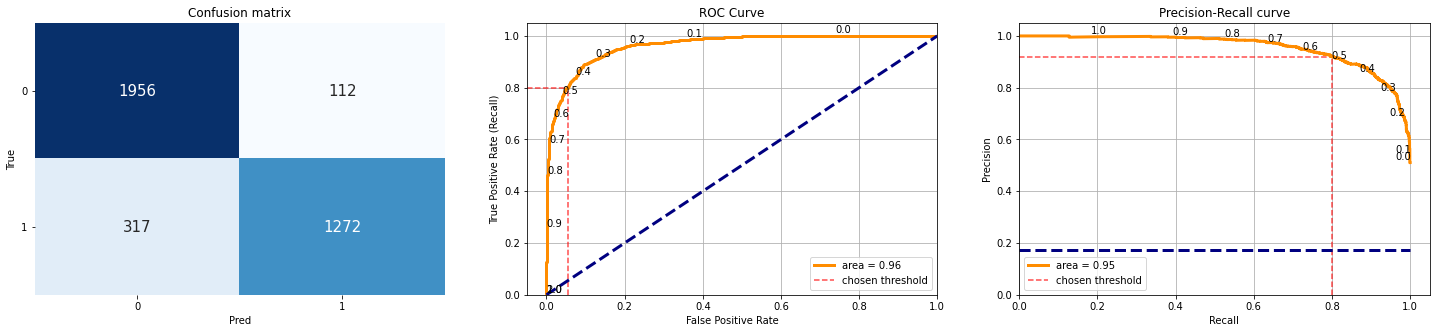

In [24]:
from sklearn.naive_bayes import MultinomialNB
nb_tfidf=MultinomialNB()
nb_tfidf.fit(X_train,y_train)
predict_MNB = nb_tfidf.predict(X_test)
predicted_prob = nb_tfidf.predict_proba(X_test)[:,1]
evaluate_model(y_test,predict_MNB, predicted_prob, figsize=(25,5))

Accuracy (overall correct predictions): 0.95
Auc: 0.99
Recall (all 1s predicted right): 0.93
Precision (confidence when predicting a 1): 0.96
F1 score: 0.94
Detail:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      2068
           1       0.96      0.93      0.94      1589

    accuracy                           0.95      3657
   macro avg       0.95      0.95      0.95      3657
weighted avg       0.95      0.95      0.95      3657



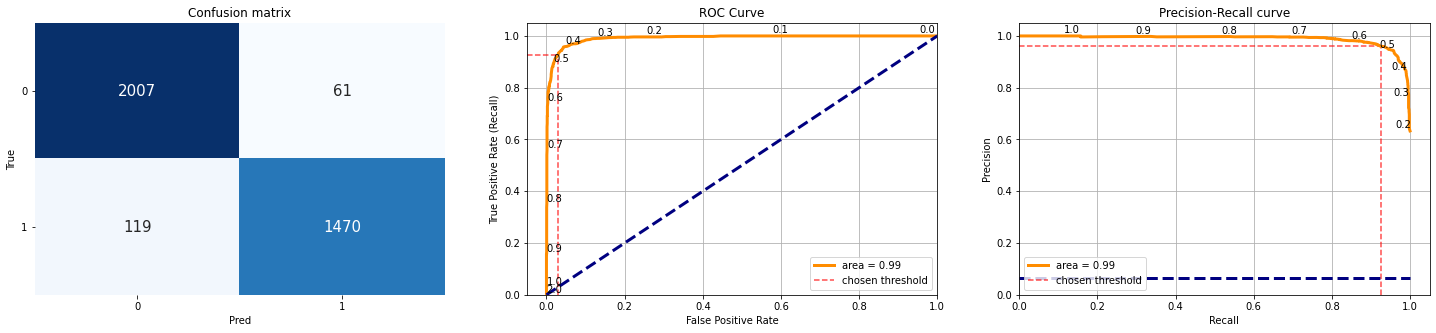

In [25]:
# implement RandomForest Classifier
from sklearn.ensemble import RandomForestClassifier
randomclassifier_tfidf=RandomForestClassifier(n_estimators=200,criterion='entropy')
randomclassifier_tfidf.fit(X_train,y_train)
predict_rf = randomclassifier_tfidf.predict(X_test)
predicted_prob_rf = randomclassifier_tfidf.predict_proba(X_test)[:,1]
evaluate_model(y_test,predict_rf, predicted_prob_rf, figsize=(25,5))

Accuracy (overall correct predictions): 0.96
Auc: 0.99
Recall (all 1s predicted right): 0.94
Precision (confidence when predicting a 1): 0.96
F1 score: 0.95
Detail:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      2068
           1       0.96      0.94      0.95      1589

    accuracy                           0.96      3657
   macro avg       0.96      0.96      0.96      3657
weighted avg       0.96      0.96      0.96      3657



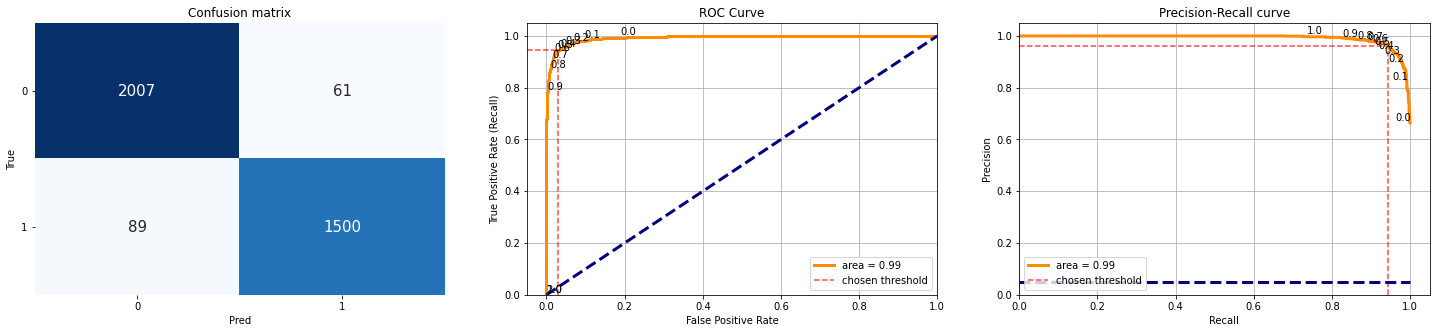

In [26]:
# implement SVC Classifier
from sklearn.svm import SVC
svc_tfidf=SVC(probability=True)
svc_tfidf.fit(X_train,y_train)
predict_svc = svc_tfidf.predict(X_test)
predicted_prob_svc = svc_tfidf.predict_proba(X_test)[:,1]
evaluate_model(y_test,predict_svc, predicted_prob_svc, figsize=(25,5))

Accuracy (overall correct predictions): 0.95
Auc: 0.99
Recall (all 1s predicted right): 0.94
Precision (confidence when predicting a 1): 0.95
F1 score: 0.94
Detail:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      2068
           1       0.95      0.94      0.94      1589

    accuracy                           0.95      3657
   macro avg       0.95      0.95      0.95      3657
weighted avg       0.95      0.95      0.95      3657



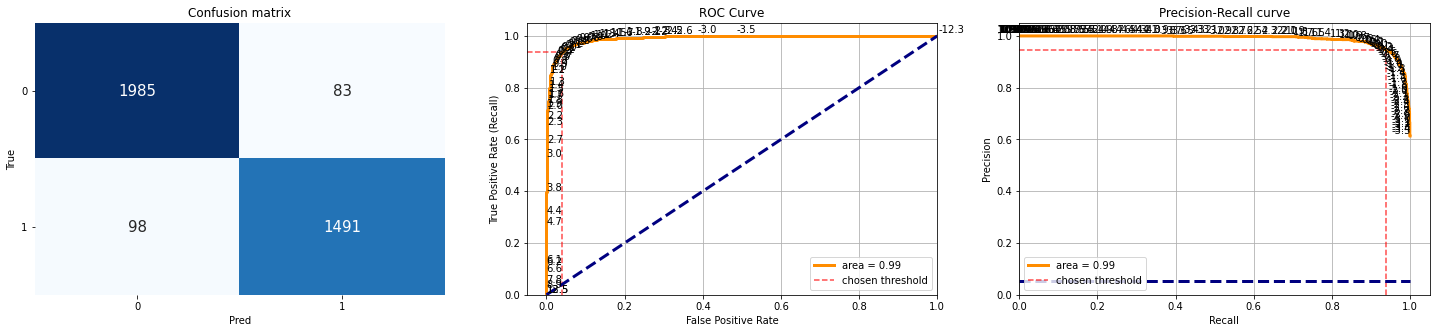

In [28]:
from sklearn.linear_model import PassiveAggressiveClassifier

pac_tfidf = PassiveAggressiveClassifier()
pac_tfidf.fit(X_train,y_train)
predict_pac = pac_tfidf.predict(X_test)
predicted_prob_pac = pac_tfidf.decision_function(X_test)
evaluate_model(y_test,predict_pac, predicted_prob_pac, figsize=(25,5))